In [1]:
import pandas as pd
from collections import Counter
import re
import os
import pickle
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/AkandeImisioluwa/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Reading NYT dataset
import pandas as pd
df_nyt = pd.read_csv("Clean_TheNewyorktimes_data.csv")

In [3]:
# Adding label to real news to the dataset and showing the column names
df_nyt["fakeness"] = 0
df_nyt.columns

Index(['Unnamed: 0', '_id', 'body', 'document_type', 'headline', 'new_desk',
       'pub_date', 'score', 'section_name', 'snippet', 'source',
       'type_of_material', 'uri', 'web_url', 'word_count', 'fakeness'],
      dtype='object')

In [4]:
# Reading The Guardian dataset
df_tguard = pd.read_csv("Clean_TheGuardian_Combined_data.csv")

In [5]:
# Adding label to real news to the dataset and showing the column names
df_tguard["fakeness"] = 0
df_tguard.columns

Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'pillarId',
       'pillarName', 'sectionId', 'sectionName', 'type', 'webPublicationDate',
       'webTitle', 'webUrl', 'bodyText', 'headline', 'fakeness'],
      dtype='object')

In [6]:
# Reading The Guardian dataset
df_fake = pd.read_csv("Clean_FakeNews_data_All.csv")

In [7]:
# Label was there for fake news dataset and showing the column names
df_fake.columns

Index(['Unnamed: 0', 'uuid', 'ord_in_thread', 'author', 'published', 'title',
       'text', 'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type',
       'fakeness'],
      dtype='object')

In [8]:
# Changing the name of the column for concating later
df_tguard = df_tguard.rename(columns={'bodyText' : 'body','webPublicationDate':'pub_date'})
df_nyt = df_nyt.rename(columns={'head_clean':'headline','_id':'id'})
df_fake = df_fake.rename(columns={'text':'body','title':'headline','uuid':'id','published':'pub_date'})
df_fake.columns,df_nyt.columns,df_tguard.columns

(Index(['Unnamed: 0', 'id', 'ord_in_thread', 'author', 'pub_date', 'headline',
        'body', 'language', 'crawled', 'site_url', 'country', 'domain_rank',
        'thread_title', 'spam_score', 'main_img_url', 'replies_count',
        'participants_count', 'likes', 'comments', 'shares', 'type',
        'fakeness'],
       dtype='object'),
 Index(['Unnamed: 0', 'id', 'body', 'document_type', 'headline', 'new_desk',
        'pub_date', 'score', 'section_name', 'snippet', 'source',
        'type_of_material', 'uri', 'web_url', 'word_count', 'fakeness'],
       dtype='object'),
 Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'pillarId',
        'pillarName', 'sectionId', 'sectionName', 'type', 'pub_date',
        'webTitle', 'webUrl', 'body', 'headline', 'fakeness'],
       dtype='object'))

In [9]:
# Dropping unnecesary columns
df_fake.drop([u'Unnamed: 0', u'ord_in_thread', u'id',
         u'language', u'crawled', u'site_url', u'country',
        u'thread_title', u'spam_score', u'replies_count', u'participants_count',
        u'likes', u'comments', u'shares', u'type', u'domain_rank',u'main_img_url',
             u'author'],inplace=True,axis=1)

df_nyt.drop([u'Unnamed: 0', u'section_name',u'new_desk',u'id', u'word_count', 
             u'document_type', u'type_of_material', u'snippet', u'uri', 
             u'source', u'score', u'web_url'],inplace=True,axis=1)

df_tguard.drop([u'Unnamed: 0', u'apiUrl', u'fields',u'id',
        u'isHosted', u'sectionId', u'sectionName', u'type',
         u'webTitle', u'webUrl',u'pillarId', u'pillarName'],inplace=True,axis=1)

In [10]:
df_nyt.head()

,body,headline,pub_date,fakeness
0,"For months, Carter Page, the former Trump camp...","{'main': 'Carter Page, Ex-Trump Aide Once Shun...",2018-02-02T23:51:20+0000,0
1,"NANAIMO, British Columbia Canadian Prime Min...","{'main': ""Canada's PM Talks Tough on NAFTA, Re...",2018-02-02T23:48:27+0000,0
2,WASHINGTON — FBI Director Christopher Wray se...,{'main': 'FBI Chief Wray Tells Staff He Stands...,2018-02-02T23:39:29+0000,0
3,WASHINGTON — The Federal Reserve is imposing ...,{'main': 'Federal Reserve Imposes New Penaltie...,2018-02-02T23:33:36+0000,0
4,WASHINGTON — The head of the U.S. House of Re...,{'main': 'House Intelligence Chairman Says Has...,2018-02-02T23:30:27+0000,0


In [11]:
df_fake.head()

,pub_date,headline,body,fakeness
0,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Govt Be...,Print They should pay all the back all the mon...,1
1,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,1
2,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : Fox News Sunday reported this morn...,1
3,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,1
4,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1


In [12]:
df_tguard.head()

,pub_date,body,headline,fakeness
0,2016-05-01T23:01:08Z,All premises in England that sell food should ...,English businesses 'should be forced to show h...,0
1,2016-05-01T23:01:07Z,"Tips in restaurants, hotels and bars should go...","Tips should go to workers, not employers, says...",0
2,2016-05-01T21:51:50Z,Election debates are more common in Holyrood p...,Sturgeon accused of breaking independence prom...,0
3,2016-05-01T21:40:37Z,Nicola Sturgeon has said a second independence...,Second Scottish independence vote not yet on t...,0
4,2016-05-01T21:16:57Z,Bernie Sanders acknowledged “an uphill climb” ...,Bernie Sanders vows a contested convention des...,0


In [13]:
# Concatenate all datasets
df_all = df_fake.append(df_tguard, ignore_index=True)
df_all = df_all.append(df_nyt,ignore_index=True)

In [14]:
#Dropping the Nan values and information
df_all.dropna(inplace=True)
print (df_all.shape)
df_all.info()

(26783, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26783 entries, 0 to 26784
Data columns (total 4 columns):
body        26783 non-null object
fakeness    26783 non-null int64
headline    26783 non-null object
pub_date    26783 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [15]:
df_all.head()

,body,fakeness,headline,pub_date
0,Print They should pay all the back all the mon...,1,Muslims BUSTED: They Stole Millions In Govt Be...,2016-10-26T21:41:00.000+03:00
1,Why Did Attorney General Loretta Lynch Plead T...,1,Re: Why Did Attorney General Loretta Lynch Ple...,2016-10-29T08:47:11.259+03:00
2,Red State : Fox News Sunday reported this morn...,1,BREAKING: Weiner Cooperating With FBI On Hilla...,2016-10-31T01:41:49.479+02:00
3,Email Kayla Mueller was a prisoner and torture...,1,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,2016-11-01T05:22:00.000+02:00
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,2016-11-01T21:56:00.000+02:00


In [16]:
df_all.to_csv("Clean_Overall_DataSet.csv")

In [17]:
df_all.head()

,body,fakeness,headline,pub_date
0,Print They should pay all the back all the mon...,1,Muslims BUSTED: They Stole Millions In Govt Be...,2016-10-26T21:41:00.000+03:00
1,Why Did Attorney General Loretta Lynch Plead T...,1,Re: Why Did Attorney General Loretta Lynch Ple...,2016-10-29T08:47:11.259+03:00
2,Red State : Fox News Sunday reported this morn...,1,BREAKING: Weiner Cooperating With FBI On Hilla...,2016-10-31T01:41:49.479+02:00
3,Email Kayla Mueller was a prisoner and torture...,1,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,2016-11-01T05:22:00.000+02:00
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,2016-11-01T21:56:00.000+02:00


## Model

In [18]:
# Preparing the targets and predictors for modeling

X_body_text = df_all.body.values
X_headline_text = df_all.headline.values
y = df_all.fakeness.values

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidfVectorize = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)

In [21]:
X_body_tfidf = tfidfVectorize.fit_transform(X_body_text)
X_headline_tfidf = tfidfVectorize.fit_transform (X_headline_text)

In [22]:
X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf,y,
test_size = 0.2, random_state=1234)
X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf,y, 
test_size = 0.2, random_state=1234)

In [23]:
# Feature Normalization
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_headline_tfidf_train)
X_train_scaled[:,0].min(),X_train_scaled[:,0].max()

(0.0, 1.0)

## Learning Curve

In [24]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
        
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
        
    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);    
            
         


### Logistic Regression

##### Using the headline of the article

In [25]:
logistic_regression_headline = LogisticRegression(penalty='l1')

In [26]:
# train model
# logistic_regression_headline.fit(X_headline_tfidf_train, y_headline_train)
logistic_regression_headline.fit(X_train_scaled, y_headline_train)

# get predictions for article section
y_headline_pred = logistic_regression_headline.predict(X_headline_tfidf_test)

In [27]:
# print metrics
print ("Logistic Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_headline_pred)*100) )

Logistic Regression F1 and Accuracy Scores : 

F1 score 61.55%
Accuracy score 83.96%


In [28]:
cros_val_list = cross_val_score(logistic_regression_headline, X_headline_tfidf,y,cv=7)
print ('cross validation list:', cros_val_list)
print ('cross validation mean:', cros_val_list.mean())

cross validation list: [ 0.86569114  0.82832506  0.84213278  0.82226869  0.82435964  0.85023523
  0.83503268]
cross validation mean: 0.838292174463


### Learning curve for Headline Logistic regression

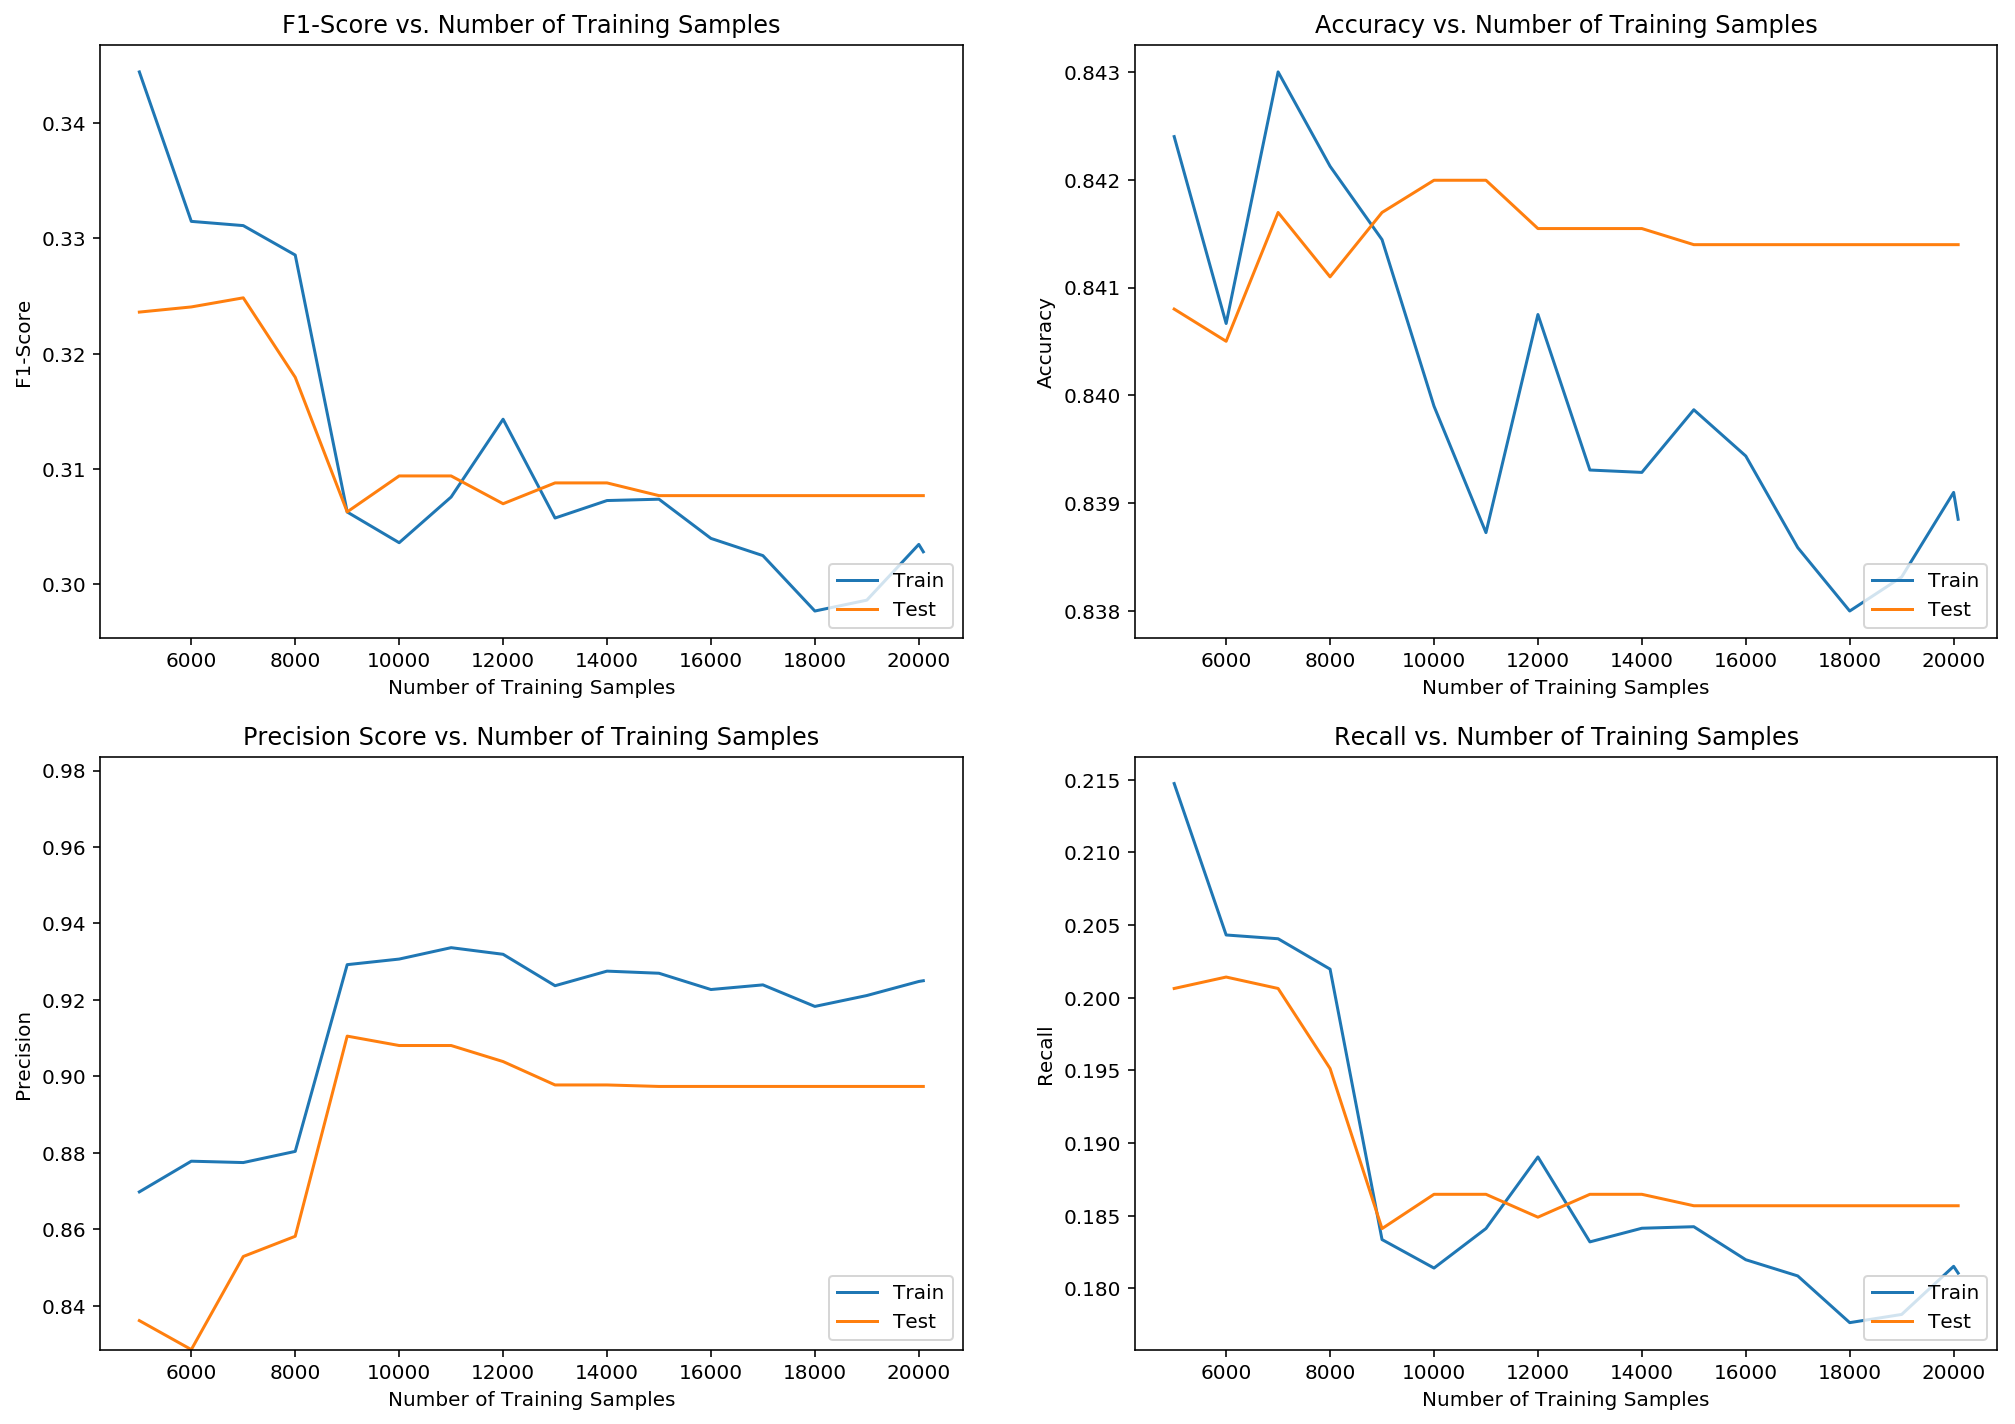

In [29]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(logistic_regression_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()



### Logistic Regression

##### Using the body of the article

In [30]:
logistic_regression_body = LogisticRegression(penalty='l1')

In [31]:
# train model
logistic_regression_body.fit(X_body_tfidf_train, y_body_train)

# get predictions for article section
y_body_pred = logistic_regression_body.predict(X_body_tfidf_test)

In [32]:
# print metrics
print ("Logistic Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_body_pred)*100) )

Logistic Regression F1 and Accuracy Scores : 

F1 score 96.12%
Accuracy score 97.67%


In [33]:
cros_val_list = cross_val_score(logistic_regression_body, X_body_tfidf,y,cv=7)
print (cros_val_list)
print (cros_val_list.mean())

[ 0.96237262  0.97543768  0.97386304  0.9613173   0.97830633  0.97569263
  0.91843137]
0.963631566764


### Learning curve for Body Logistic regression

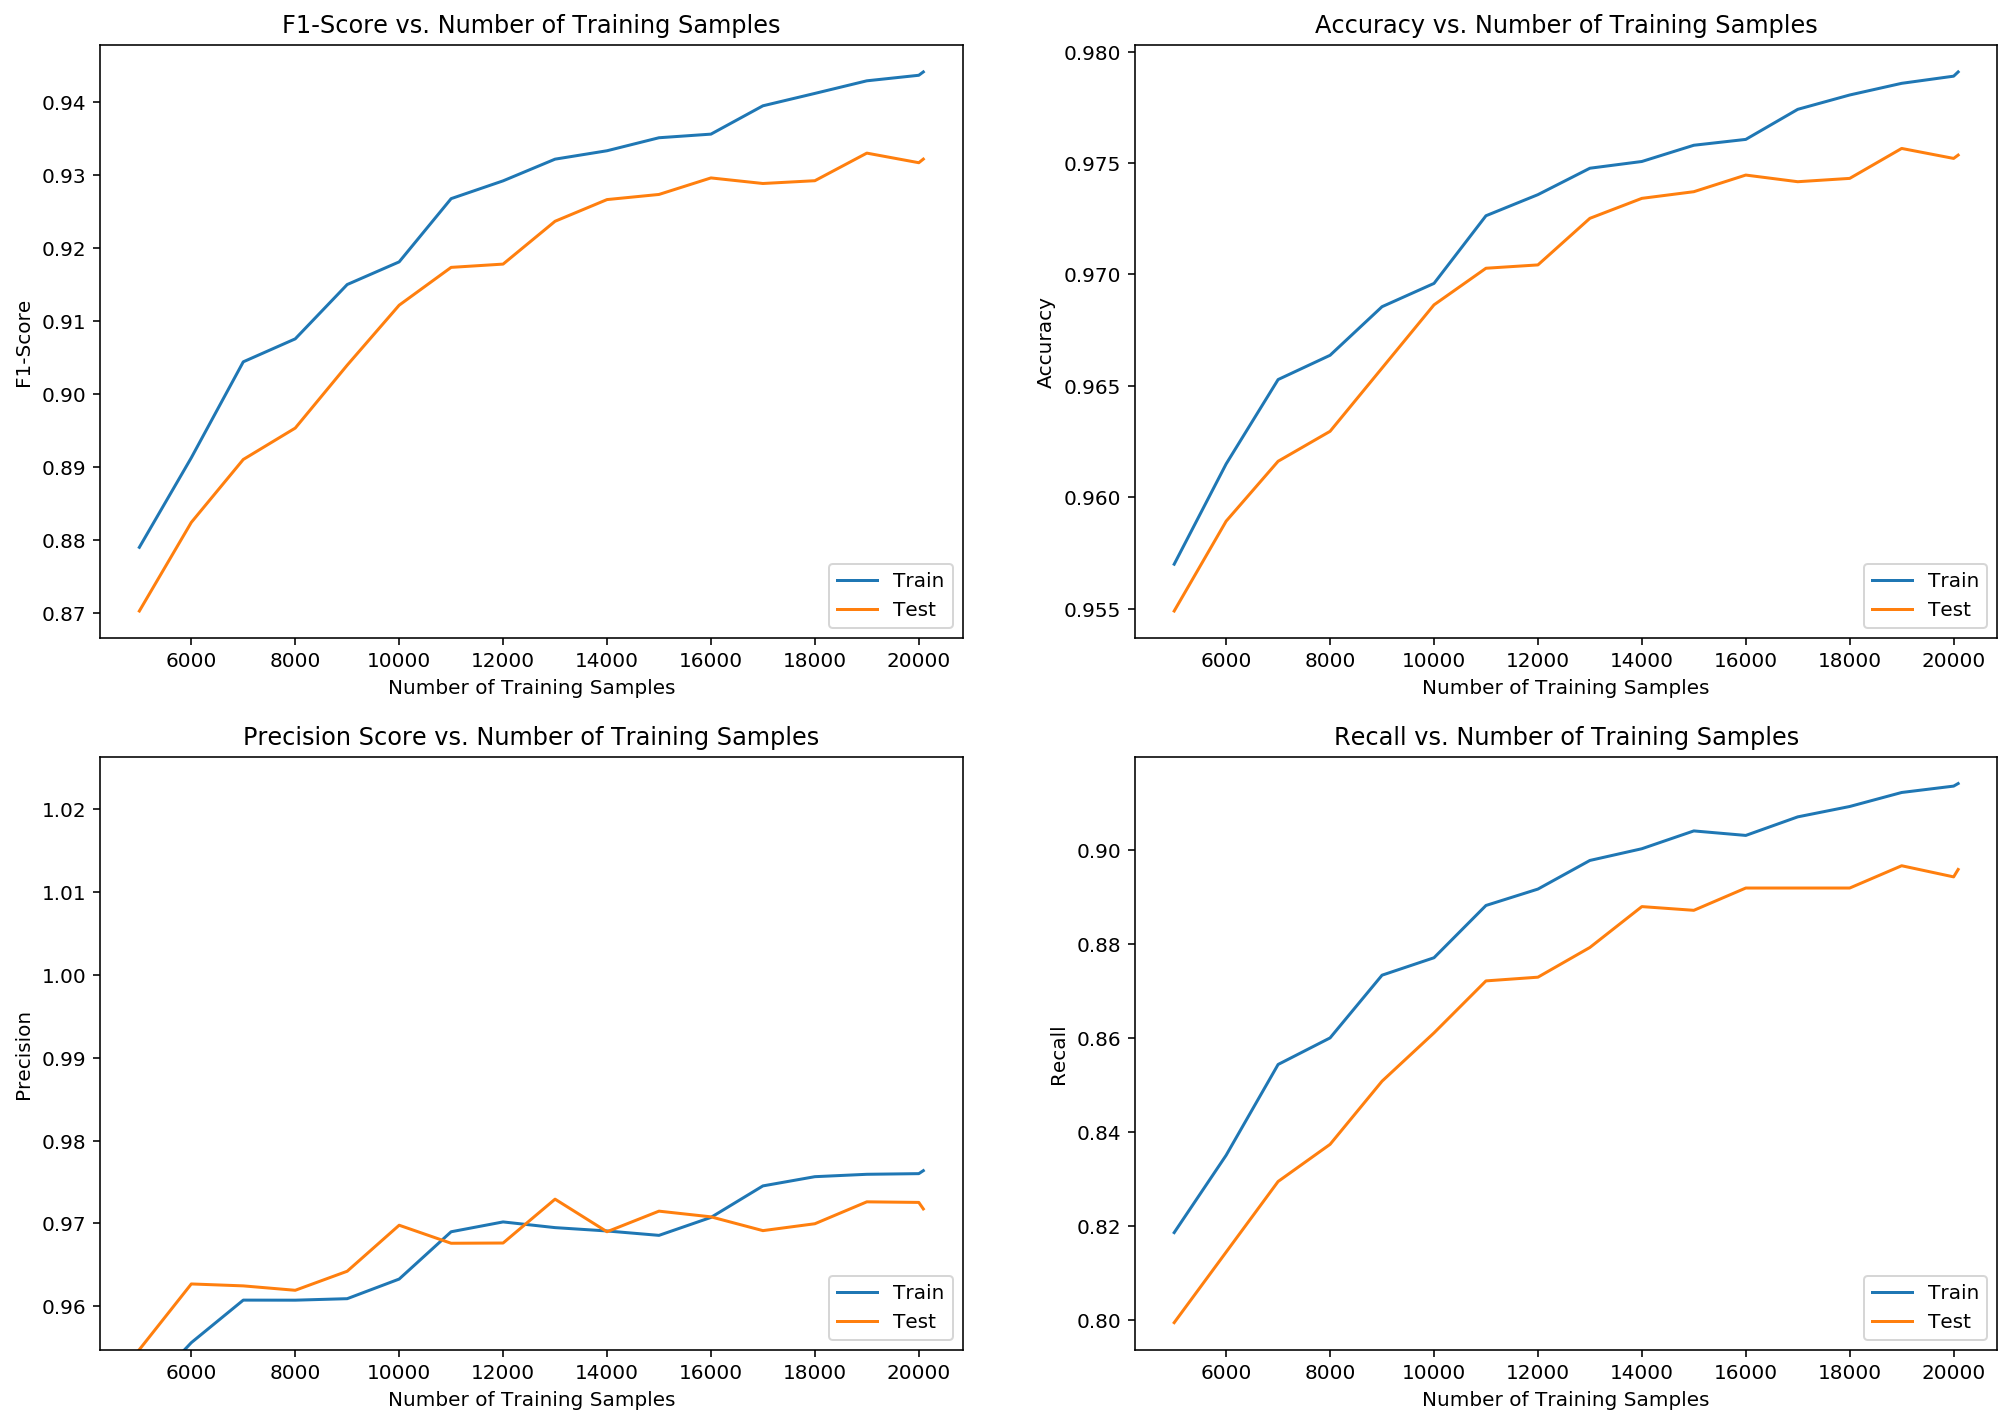

In [34]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(logistic_regression_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [35]:
import os
import pickle
#create file path
model_file_path = os.path.join(os.path.pardir, './client/lr_model.pkl')
scaler_file_path = os.path.join(os.path.pardir, './client/lr_scaler.pkl')
#open the files to write
model_file_pickle = open(model_file_path, 'wb')
scaler_file_pickle = open(scaler_file_path, 'wb')
#persist the model and scaler
pickle.dump(logistic_regression_body, model_file_pickle)
pickle.dump(scaler, scaler_file_pickle)
# close the file
model_file_pickle.close()
scaler_file_pickle.close()

## Load the persisted file

In [36]:
# open files in read mode
model_file_pickle = open(model_file_path, 'rb')
scaler_file_pickle = open(scaler_file_path, 'rb')
# load files
clf_loaded = pickle.load(model_file_pickle)
scaler_loaded = pickle.load(scaler_file_pickle)
# close files
model_file_pickle.close
scaler_file_pickle.close
clf_loaded


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
scaler_loaded 

MaxAbsScaler(copy=True)

In [38]:
X_test_scaled = scaler.transform(X_headline_tfidf_test)

In [39]:
machine_learning_api_script_file = os.path.join(os.path.pardir,'./client/machine_learning_api.py')


In [40]:
%%writefile $machine_learning_api_script_file

from flask import Flask, request
import pandas as pd
import sklearn
import numpy as np
import json
import pickle
import os

app = Flask(__name__)

# Load model and scaler files
model_file_path = os.path.join(os.path.pardir, './client/lr_model.pkl')
scaler_file_path = os.path.join(os.path.pardir, './client/lr_scaler.pkl')

scaler = pickle.load(open(scaler_file_path, 'rb'))
model = pickle.load(open(model_file_path, 'rb'))

# columns
columns = [u'id', u'body', u'headline', u'pub_date']

@app.route('/api', methods=['POST'])
def make_prediction():
    # read json object and convert to json string
    data = json.dumps(request.get_json(force=True))
    # create pandas data frame using json string
    df = pd.read_json(data)
    # extract news id 
    news_ids = df['id'].ravel()
    # actual fake news
    actuals = df['fakeness'].ravel()
    #X = df[columns].values.astype('float')
    #s1 = pd.Series([1,2])
    X = df[columns].astype('string', copy=False)
    X_scaled = scaler.transform(X)
    predictions = model.predict(X_scaled)
    df_response = pd.DataFrame({'id':news_ids, 'Predicted':predictions, 'Actual':actuals})
    
    #return json
    return df_response.to_json()

if __name__ == '__main__':
    #host flask app at port 10001
    
    app.run(port=10001, debug=True)
    
    



Overwriting .././client/machine_learning_api.py


In [41]:
import os 
import pandas as pd
processed_data_path = os.path.join(os.path.pardir,'processed')
train_file_path = os.path.join(os.path.pardir,'./client/Clean_Overall_DataSet.csv')
train_df = pd.read_csv(train_file_path)

fake_news = train_df[train_df['fakeness'] == 0][:5]
fake_news



,Unnamed: 0,body,fakeness,headline,pub_date
5154,5156,All premises in England that sell food should ...,0,English businesses 'should be forced to show h...,2016-05-01T23:01:08Z
5155,5157,"Tips in restaurants, hotels and bars should go...",0,"Tips should go to workers, not employers, says...",2016-05-01T23:01:07Z
5156,5158,Election debates are more common in Holyrood p...,0,Sturgeon accused of breaking independence prom...,2016-05-01T21:51:50Z
5157,5159,Nicola Sturgeon has said a second independence...,0,Second Scottish independence vote not yet on t...,2016-05-01T21:40:37Z
5158,5160,Bernie Sanders acknowledged “an uphill climb” ...,0,Bernie Sanders vows a contested convention des...,2016-05-01T21:16:57Z
